# From text to models in World Modelers

## Choose text corpus to process

In [1]:
text = """The government promotes improved cultivar to boost agricultural production for ensuring food security. 
However, the policy to seriously cut down the use of inorganic fertilizer and 
phase out the fertilizer subsidy results in deteriorating biophysical conditions, 
low use of inorganic fertilizer, less water, significantly reduced farm sizes 
which lead to low benefit from the improved cultivar."""

## Read text via interface to Eidos system

In [2]:
from indra.sources import eidos

In [3]:
eidos_processor = eidos.process_text(text)

## Instantiated INDRA Influence Statements

In [4]:
statements = eidos_processor.statements

In [5]:
statements

[Influence(biophysical conditions(negative), benefit(negative)),
 Influence(farm sizes(negative), benefit(negative)),
 Influence(use of inorganic fertilizer(negative), farm sizes(negative)),
 Influence(government, agricultural production(positive)),
 Influence(government, agricultural production(positive)),
 Influence(government, cultivar(positive)),
 Influence(government, cultivar(positive)),
 Influence(cultivar(positive), benefit(negative)),
 Influence(policy, biophysical conditions(negative)),
 Influence(agricultural production(positive), food security),
 Influence(agricultural production(positive), food security)]

## Assemble into graph and visualize

In [6]:
from indra.assemblers import GraphAssembler

In [7]:
ga = GraphAssembler(statements)

In [8]:
ga.make_model()

In [9]:
ga.save_pdf('model_graph.pdf')

In [10]:
from IPython.display import IFrame
IFrame("model_graph.pdf", width=600, height=500)

## Assemble into a system of ODEs and simulate

In [11]:
from indra.assemblers import PysbAssembler
from pysb.simulator import ScipyOdeSimulator; import numpy; import matplotlib.pyplot as plt; plt.ion()

In [12]:
pa = PysbAssembler()

In [13]:
pa.add_statements(statements)

In [14]:
model = pa.make_model()

In [15]:
ts = numpy.linspace(0, 100000)
sim = ScipyOdeSimulator(model, ts)

In [16]:
res = sim.run()

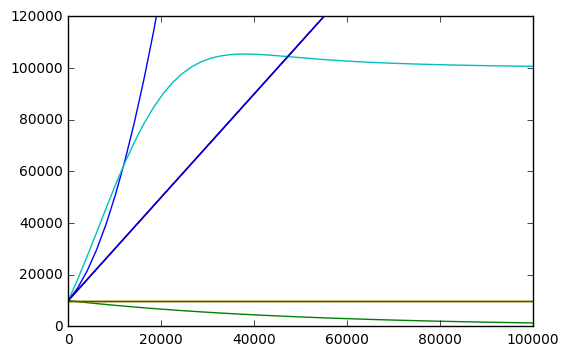

In [17]:
plt.figure()
plt.xlim(0, 100000)
plt.ylim(0, 120000)
for i, cp in enumerate(model.species):
    plt.plot(ts, res.all['__s%d' % i], label=str(cp))

## Assemble into a Bayesian Network represented as a Figaro model

In [18]:
from indra.assemblers import FigaroAssembler

In [25]:
fa = FigaroAssembler(statements, readout='benefit')

In [26]:
fa.make_model()

In [27]:
print(fa.print_model('IndraModel.scala'))

import com.cra.figaro.language._
import com.cra.figaro.library.atomic._
import com.cra.figaro.library.compound._
import com.cra.figaro.library.atomic.continuous.Normal
import com.cra.figaro.algorithm.sampling.Importance

object IndraModel {
val food_security = Chain(agricultural_production, (v:Double) => Normal(v, 0.2))
val agricultural_production = Chain(government, (v:Double) => Normal(v, 0.2))
val use_of_inorganic_fertilizer = Normal(1,0.2)
val benefit = Chain(^^(farm_sizes,biophysical_conditions,cultivar), (v:(Double,Double,Double)) => Normal(+ 1.00 * v._1 + 1.00 * v._2 + 1.00 * v._3, 0.2))
val farm_sizes = Chain(use_of_inorganic_fertilizer, (v:Double) => Normal(v, 0.2))
val policy = Normal(1,0.2)
val biophysical_conditions = Chain(policy, (v:Double) => Normal(v, 0.2))
val cultivar = Chain(government, (v:Double) => Normal(v, 0.2))
val government = Normal(1,0.2)
def main(args:Array[String]) = {var importance = Importance(100000, benefit)
importance.start()
val expv = importance.comp